# Basic portfolio optimization problem using `CVXPY`

### Dr. Tirthajyoti Sarkar 
### Fremont, CA, May 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxpy import *

### Read the data (please make sure that the CSV data file is in the same directory as this Notebook)

In [2]:
mp = pd.read_csv("Data/monthly_prices.csv",index_col=0)
mr = pd.DataFrame()

In [3]:
mp.head()

,MSFT,V,WMT
1,44.259998,69.660004,64.839996
2,52.639999,77.580002,57.240002
3,54.349998,79.010002,58.840000
4,55.480000,77.550003,61.299999
5,55.090000,74.489998,66.360001


### Plot the data

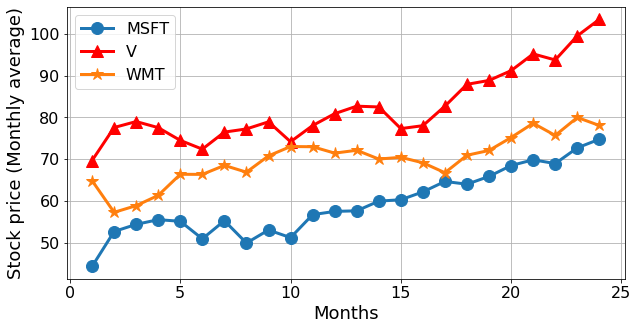

In [4]:
plt.figure(figsize=(10,5))
plt.plot([i for i in range(1,25)],mp['MSFT'],lw=3,marker='o',markersize=12)
plt.plot([i for i in range(1,25)],mp['V'],lw=3,c='red',marker='^',markersize=12)
plt.plot([i for i in range(1,25)],mp['WMT'],lw=3,marker='*',markersize=12)
plt.legend(mp.columns,fontsize=16)
plt.xlabel("Months",fontsize=18)
plt.ylabel("Stock price (Monthly average)",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

### Compute monthly returns

In [8]:
# compute monthly returns
for s in mp.columns:
    date = mp.index[0]
    pr0 = mp[s][date] 
    for t in range(1,len(mp.index)):
        date = mp.index[t]
        pr1 = mp[s][date]
        ret = (pr1-pr0)/pr0
        mr.at[date,s] = ret
        pr0 = pr1

In [9]:
mr.head()

,MSFT,V,WMT
2,0.189336,0.113695,-0.117212
3,0.032485,0.018433,0.027952
4,0.020791,-0.018479,0.041808
5,-0.007030,-0.039458,0.082545
6,-0.076420,-0.028192,-0.000301


### Get symbol names

In [10]:
# get symbol names
symbols = mr.columns

### Convert monthly return data frame to a numpy matrix

In [12]:
return_data = mr.to_numpy().T

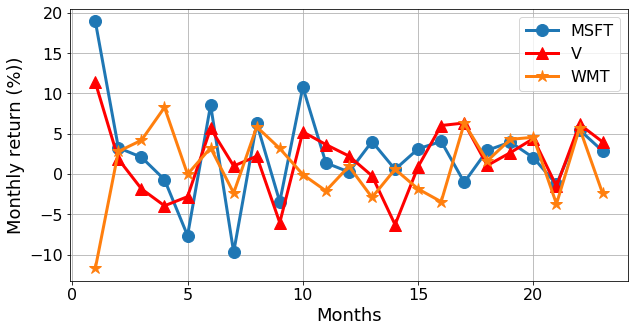

In [13]:
plt.figure(figsize=(10,5))
plt.plot([i for i in range(1,24)],100*mr['MSFT'],lw=3,marker='o',markersize=12)
plt.plot([i for i in range(1,24)],100*mr['V'],lw=3,c='red',marker='^',markersize=12)
plt.plot([i for i in range(1,24)],100*mr['WMT'],lw=3,marker='*',markersize=12)
plt.legend(mp.columns,fontsize=16)
plt.xlabel("Months",fontsize=18)
plt.ylabel("Monthly return (%))",fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

### Mean return

In [14]:
r = np.asarray(np.mean(return_data, axis=1))

### Covariance matrix

In [15]:
C = np.asmatrix(np.cov(return_data))

In [16]:
C

matrix([[ 0.00336865,  0.0016328 , -0.00075249],
        [ 0.0016328 ,  0.00183242, -0.00056339],
        [-0.00075249, -0.00056339,  0.00197676]])

### Print expected returns and risk

In [17]:
for j in range(len(symbols)):
    print ('%s: Exp ret = %f, Risk = %f' %(symbols[j],r[j], C[j,j]**0.5))

MSFT: Exp ret = 0.024611, Risk = 0.058040
V: Exp ret = 0.018237, Risk = 0.042807
WMT: Exp ret = 0.009066, Risk = 0.044461


### Set up the optimization model

In [18]:
# Number of variables
n = len(symbols)

# The variables vector
x = Variable(n)

# The minimum return
req_return = 0.02

# The return
ret = r.T*x

# The risk in xT.Q.x format
risk = quad_form(x, C)

# The core problem definition with the Problem class from CVXPY
prob = Problem(Minimize(risk), [sum(x)==1, ret >= req_return, x >= 0])

/home/andreas/anaconda3/envs/py38/lib/python3.8/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


### Try solving the problem (within a `try/except` loop)

In [19]:
try:
    prob.solve()
    print ("Optimal portfolio")
    print ("----------------------")
    for s in range(len(symbols)):
       print (" Investment in {} : {}% of the portfolio".format(symbols[s],round(100*x.value[s],2)))
    print ("----------------------")
    print ("Exp ret = {}%".format(round(100*ret.value,2)))
    print ("Expected risk    = {}%".format(round(100*risk.value**0.5,2)))
except:
    print ("Error")

Optimal portfolio
----------------------
 Investment in MSFT : 58.28% of the portfolio
 Investment in V : 20.43% of the portfolio
 Investment in WMT : 21.29% of the portfolio
----------------------
Exp ret = 2.0%
Expected risk    = 3.83%


In [20]:
prob.status

'optimal'

In [21]:
x.value

array([0.58281755, 0.20432414, 0.21285832])